In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import pyemma as pye
import glob
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
import mdtraj
import nglview
matplotlib.__version__

_ColormakerRegistry()

'3.1.0'

In [2]:
path=os.path.join('/Volumes/Vikas\'s Drive','Trajectories_processed','POPC-CHOL')
traj_files = glob.glob(path + "/*.xtc") 
pdb_files = glob.glob(path + "/*.pdb")
traj_files

["/Volumes/Vikas's Drive/Trajectories_processed/POPC-CHOL/all-10.xtc",
 "/Volumes/Vikas's Drive/Trajectories_processed/POPC-CHOL/combined.xtc",
 "/Volumes/Vikas's Drive/Trajectories_processed/POPC-CHOL/trajout.xtc"]

## Feature Selection

In [3]:
feature = pye.coordinates.featurizer("/Volumes/Vikas's Drive/Trajectories_processed/POPC-CHOL/no-chol.pdb")
feature.add_minrmsd_to_ref(ref_frame=0, ref="/Volumes/Vikas's Drive/Trajectories_processed/POPC-CHOL/no-chol.pdb")
reader = pye.coordinates.source(traj_files[1], features=feature)

## load saved data

In [11]:
RMSD_obj=reader.get_output()

In [12]:
RMSD_obj_conc=np.concatenate(RMSD_obj)
with open('RMSD-protein-CHOL-full-traj.dat','w') as f:
    np.savetxt(f,RMSD_obj_conc)

In [5]:
RMSD_obj_conc=np.genfromtxt('RMSD-protein-CHOL-full-traj.dat')
RMSD_obj_conc=RMSD_obj_conc.reshape(-1,1)
len(RMSD_obj_conc)

128001

Text(0.5, 0, 'RMSD(nm)')

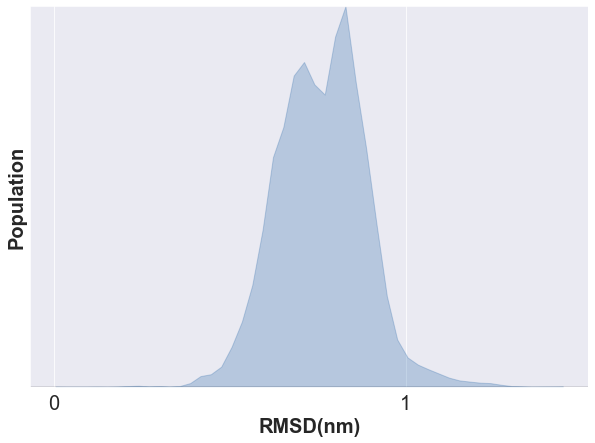

In [9]:
diverging_colors = sns.color_palette("RdBu", 10)
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 1, figsize=(10, 7))
pye.plots.plot_feature_histograms(RMSD_obj_conc, feature_labels=np.arange(0,1).tolist(), ax=axes,color=diverging_colors[9],)
plt.xticks( np.arange(0,1.5), size=20)
plt.ylabel('Population', size=20, weight='bold')
plt.yticks([],size=20)
plt.xlabel( 'RMSD(nm)',size=20, weight='bold')

In [5]:
from sklearn.cluster import KMeans
convergence_kmeans=[]
for i in range(100,1):
    kmeans=KMeans(n_clusters=i, random_state=0).fit(RMSD_obj_conc)
    convergence_kmeans.append(kmeans.inertia_)

Text(0.5, 0, 'Number of clusters')

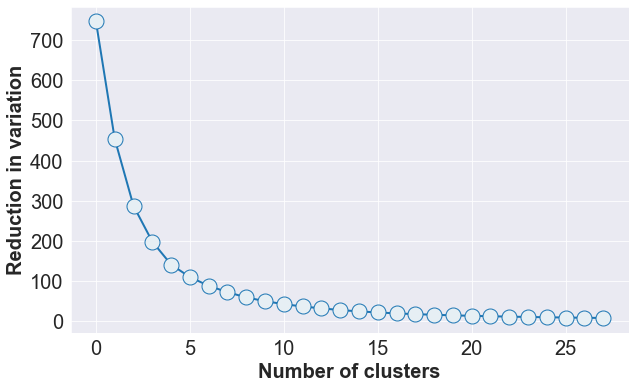

In [8]:
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
plt.plot(convergence_kmeans, marker='o',ms=15, lw=2, markerfacecolor=diverging_colors[5])
plt.xticks( np.arange(0,30,5), size=20)
plt.ylabel('Reduction in variation', size=20, weight='bold')
plt.yticks(size=20)
plt.xlabel('Number of clusters', size=20, weight='bold')

In [101]:
cluster = pye.coordinates.cluster_kmeans(RMSD_obj_conc, k=200, max_iter=100)
dtrajs = cluster.dtrajs

In [151]:
lags = [1,10,25, 50, 100, 250 , 300, 400, 500,750, 1000,1200, 1500,1750,2000]
its = pye.msm.its(dtrajs, lags=lags,errors='bayes')

TypeError: timescales_msm() got an unexpected keyword argument 'dt'

Text(0, 0.5, 'Timescale/steps')

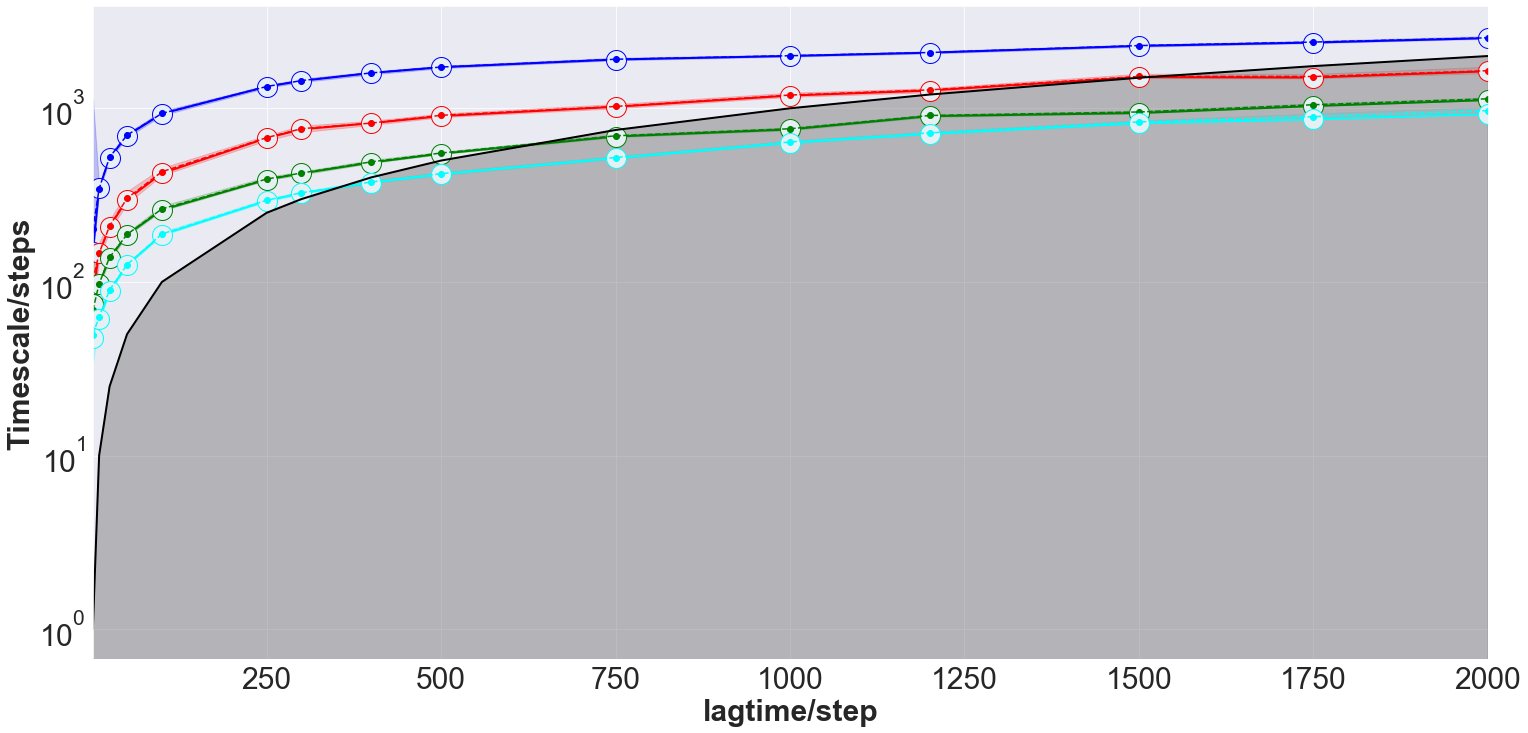

In [160]:
fig, axes = plt.subplots(figsize=(25,12))
pye.plots.plot_implied_timescales(its, marker='o', ms=20, lw=2, markerfacecolor=diverging_colors[5], nits=4 )

plt.xticks(size=30)
plt.xlabel('lagtime/step', size=30, weight='bold')
plt.yticks(size=30)
plt.ylabel('Timescale/steps', size=30, weight='bold')

## MSM estimation

In [154]:
M = pye.msm.estimate_markov_model(dtrajs,300)

In [155]:
len(dtrajs[0])

128001

In [156]:
print('fraction of states used = {:f}'.format(M.active_state_fraction))
print('fraction of counts used = {:f}'.format(M.active_count_fraction))

fraction of states used = 1.000000
fraction of counts used = 1.000000


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]), <a list of 10 Text yticklabel objects>)

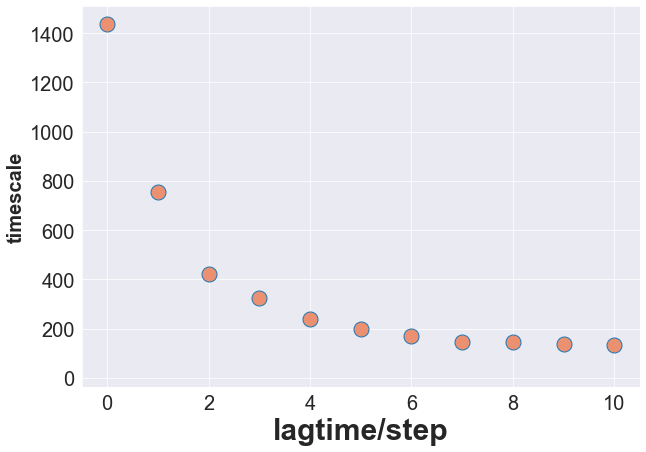

In [157]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(figsize=(10,7))
plt.plot(M.timescales(),linewidth=0,marker='o',ms=15,markerfacecolor=diverging_colors[2])
plt.xlabel('index', size=20,weight='bold')
plt.ylabel('timescale', size=20, weight='bold')
plt.xlim(-0.5,10.5)
plt.xticks(size=20)
plt.xlabel('lagtime/step', size=30, weight='bold')
plt.yticks(size=20)

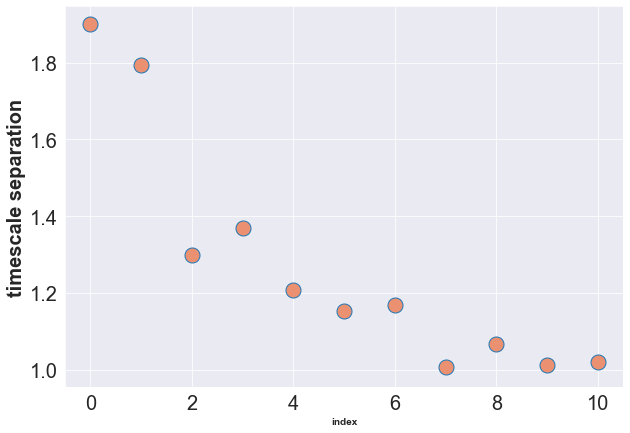

In [162]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(figsize=(10,7))
plt.plot(M.timescales()[:-1]/M.timescales()[1:], linewidth=0,marker='o', ms=15,markerfacecolor=diverging_colors[2])
plt.xlabel('index', size=10,weight='bold')
plt.ylabel('timescale separation', size=20, weight='bold')
plt.xlim(-0.5,10.5)
plt.xticks(size=20)
plt.yticks(size=20)
plt.savefig('Timescale-sep.png',dpi=300)

(<Figure size 720x720 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a63bca2e8>,
       dtype=object))

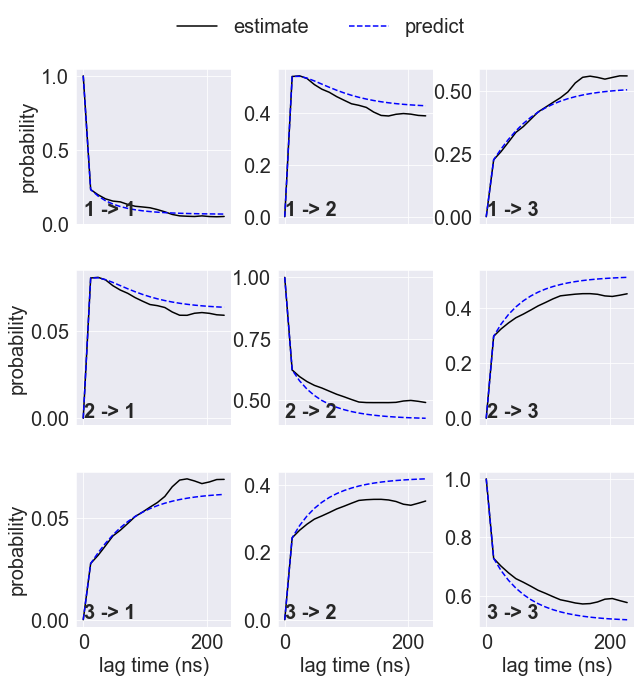

In [161]:
sns.set_style('darkgrid')
n_sets = 3
ck = M.cktest(n_sets, mlags=20, err_est=True, show_progress=True)

plt.rcParams.update({'font.size': 20})
pye.plots.plot_cktest(ck, diag=False, figsize=(10,10),layout=(n_sets,n_sets), padding_top=0.1, dt=0.04, y01=False, padding_between=0.3, units='ns')


In [146]:
for i, s in enumerate(M.metastable_sets):
    print('π_{} = {:f}'.format(i + 1, M.pi[s].sum()))

π_1 = 0.008478
π_2 = 0.570863
π_3 = 0.420659


In [147]:
hmm = M.coarse_grain(3)

In [148]:
hmm.stationary_distribution

array([0.2585, 0.3161, 0.4254])

In [149]:
np.set_printoptions(precision=4, suppress=True)
print(hmm.transition_matrix)

[[0.9744 0.0239 0.0017]
 [0.0195 0.9587 0.0218]
 [0.001  0.0162 0.9828]]


/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


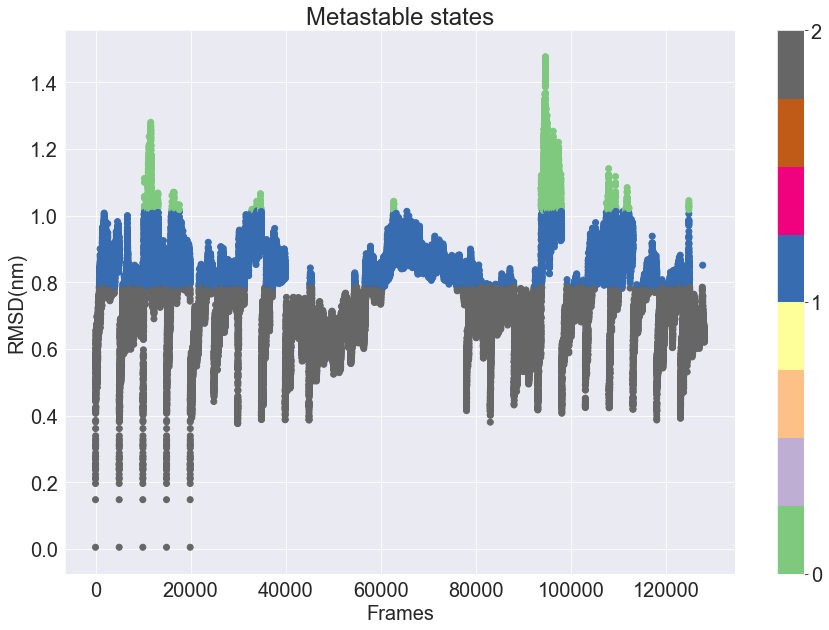

In [163]:
metastable_traj = M.metastable_assignments[dtrajs]
highest_membership = M.metastable_distributions.argmax(1)
highest_membership_value = M.metastable_distributions.max(1)
coarse_state_centers = cluster.clustercenters[M.active_set[highest_membership]]

sns.set_style('darkgrid')
plt.figure(figsize=(15,10))
plt.scatter(y=RMSD_obj_conc,x=range(0,len(RMSD_obj_conc)),c=metastable_traj, cmap=plt.cm.Accent)
plt.ylabel('RMSD(nm)')
plt.xlabel('Frames')
plt.title('Metastable states')
plt.colorbar(ticks=[0,1,2])

In [126]:
metastable_traj=metastable_traj.reshape(-1,1)

In [164]:
highest_membership

array([ 36,  76, 117])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a599dfba8>,
      dtype=object)

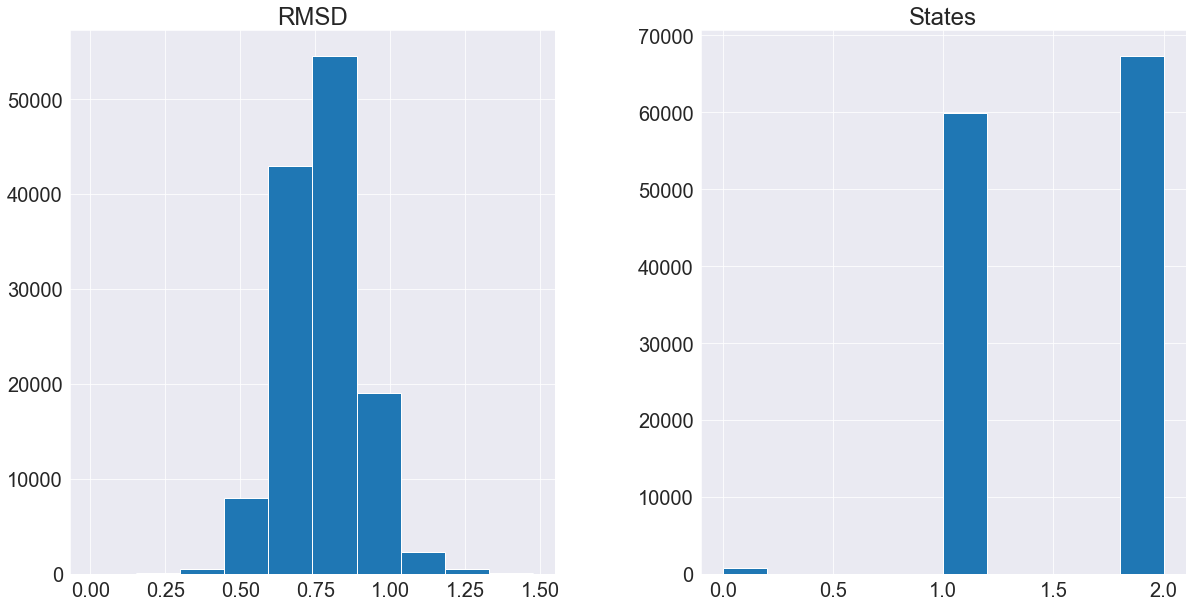

In [127]:
data=np.hstack((RMSD_obj_conc,metastable_traj))
df=pd.DataFrame(data)
df.columns=['RMSD','States']
df.hist(figsize=(20,10))

In [128]:
df['States'].value_counts()/ df['States'].value_counts().sum()

2.0    0.525902
1.0    0.468512
0.0    0.005586
Name: States, dtype: float64

IndexError: index 2 is out of bounds for axis 1 with size 2

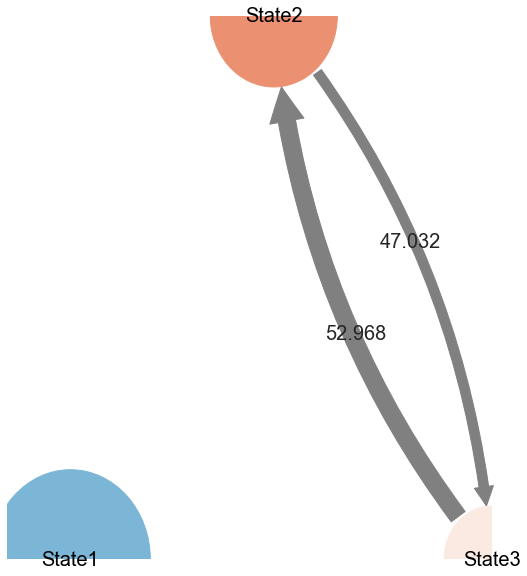

In [131]:
#pos=np.array([[0,0.29],[0.49,0],[1.01,0.28]])
pos=np.array([
        [0.9992, 0.0],
        [0.55    , 1. ],
        [0.1304, 0.    ]])
pye.plots.plot_markov_model(hmm,state_scale=1.2,pos=pos, max_height=10, arrow_scale=1.5, arrow_curvature=2, max_width=10, arrow_labels=trans_mat, arrow_label_format='%0.3f' ,state_labels=np.array(['State3','State2','State1']) ,state_colors=[diverging_colors[4],diverging_colors[2],diverging_colors[7]])
#pye.plots.plot_markov_model(hmm)

In [52]:
trans_mat=hmm.transition_matrix
trans_mat=trans_mat*100/3
trans_mat1=trans_mat
np.fill_diagonal(trans_mat1,0)
trans_mat=(trans_mat/trans_mat1.sum())*100


In [53]:
nstates=3
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = M.mfpt(
            M.metastable_sets[i],
            M.metastable_sets[j])


mfpt=(mfpt*40)/1000
MPT=pd.DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))



([<matplotlib.axis.YTick at 0x1a5ae90860>,
 <a list of 3 Text yticklabel objects>)

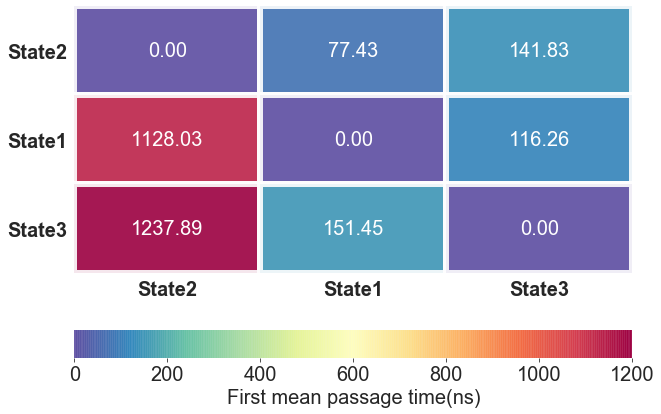

In [56]:
plt.figure(figsize=(10,7))

sns.heatmap(data=MPT,lw=5, annot=True,fmt="0.2f", cmap='Spectral_r',alpha=0.9, vmin=0, vmax=1200, cbar_kws={'label':'First mean passage time(ns)','orientation':'horizontal'})
plt.xticks(np.arange(0.5,3.5),['State2','State1','State3'], weight='bold')
plt.yticks(np.arange(0.5,3.5),['State2','State1','State3'], rotation=0, weight='bold')

In [57]:
pcca_samples = M.sample_by_distributions(M.metastable_distributions,100)

In [58]:
outfiles = []
for k in range(0, 3):
    intstring = str(k+1)
    filename = 'samples_pcca_RMSD'+ intstring + '.xtc'
    outfiles.append(filename)

pye.coordinates.save_trajs(reader, pcca_samples, outfiles = outfiles)

['samples_pcca_RMSD1.xtc', 'samples_pcca_RMSD2.xtc', 'samples_pcca_RMSD3.xtc']

In [40]:
vis_set = 1
traj_sample = mdtraj.load_xtc('samples_pcca_RMSD'+ str(vis_set) + '.xtc', top=pdb_files[1], stride = 1)
w = nglview.show_mdtraj(traj_sample)
w.clear_representations()
w.add_representation('cartoon', selection='all', color_scheme = 'hydrophobicity')
w

NGLWidget(max_frame=99)

In [59]:
### state 2

In [88]:
M = pye.msm.estimate_markov_model(dtrajs,500)

(<Figure size 720x720 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1abfb51588>,
       dtype=object))

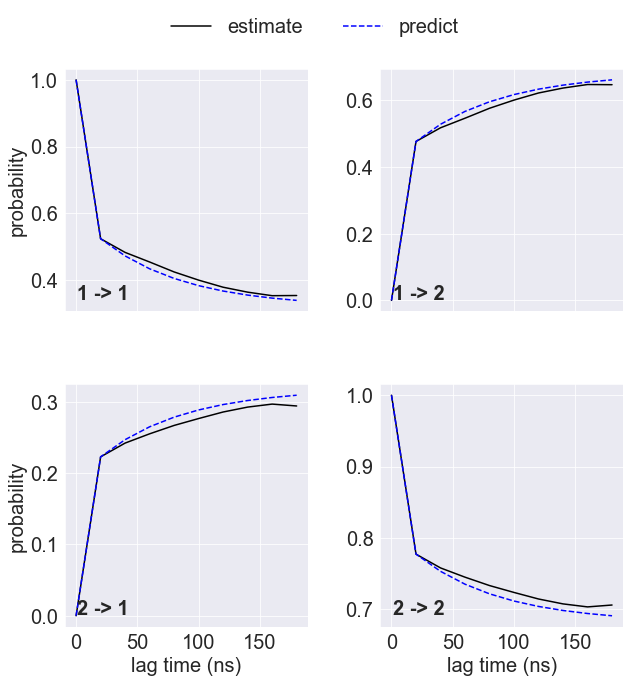

In [107]:
sns.set_style('darkgrid')
n_sets = 2
ck = M.cktest(n_sets, mlags=10, err_est=True, show_progress=True)

plt.rcParams.update({'font.size': 20})
pye.plots.plot_cktest(ck, diag=False, figsize=(10,10),layout=(n_sets,n_sets), padding_top=0.1, dt=0.04, y01=False, padding_between=0.3, units='ns')


In [108]:
hmm = M.coarse_grain(2)

In [109]:
hmm.stationary_distribution

array([0.47, 0.53])

In [110]:
np.set_printoptions(precision=4, suppress=True)
print(hmm.transition_matrix)

[[0.8983 0.1017]
 [0.0902 0.9098]]


/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


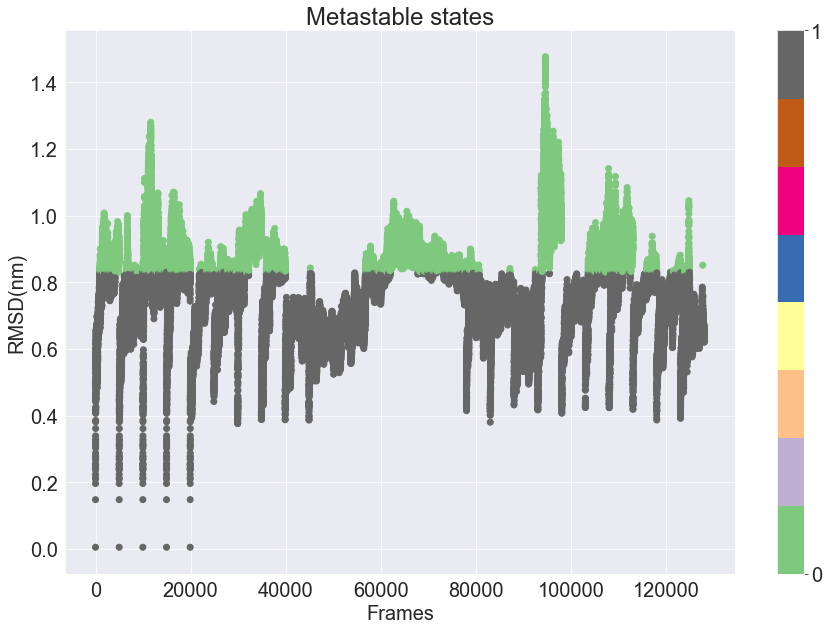

In [111]:
metastable_traj = M.metastable_assignments[dtrajs]
highest_membership = M.metastable_distributions.argmax(1)
highest_membership_value = M.metastable_distributions.max(1)
coarse_state_centers = cluster.clustercenters[M.active_set[highest_membership]]

sns.set_style('darkgrid')
plt.figure(figsize=(15,10))
plt.scatter(y=RMSD_obj_conc,x=range(0,len(RMSD_obj_conc)),c=metastable_traj, cmap=plt.cm.Accent)
plt.ylabel('RMSD(nm)')
plt.xlabel('Frames')
plt.title('Metastable states')
plt.colorbar(ticks=[0,1,2])

In [75]:
metastable_traj=metastable_traj.reshape(-1,1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a55e7aef0>,
      dtype=object)

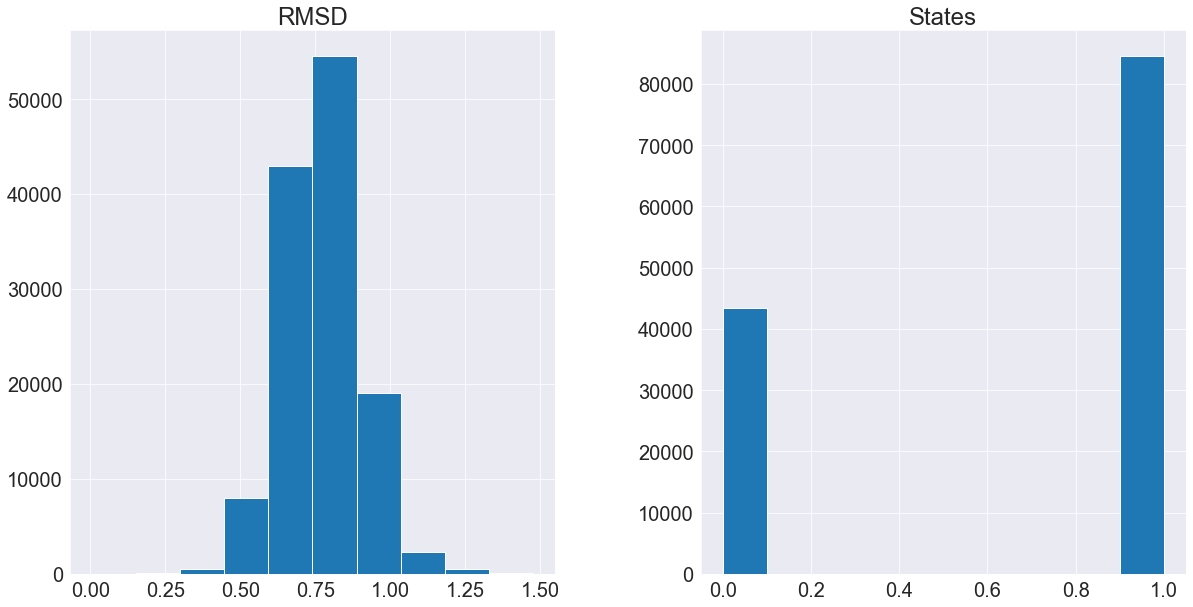

In [76]:
data=np.hstack((RMSD_obj_conc,metastable_traj))
df=pd.DataFrame(data)
df.columns=['RMSD','States']
df.hist(figsize=(20,10))

In [77]:
df['States'].value_counts()/ df['States'].value_counts().sum()

1.0    0.66055
0.0    0.33945
Name: States, dtype: float64

In [78]:
trans_mat=hmm.transition_matrix
trans_mat=trans_mat*100/2
trans_mat1=trans_mat
np.fill_diagonal(trans_mat1,0)
trans_mat=(trans_mat/trans_mat1.sum())*100


(<Figure size 323.424x720 with 1 Axes>, array([[0.9992, 0.    ],
        [0.55  , 1.    ]]))

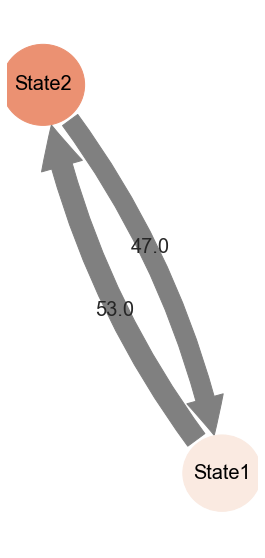

In [80]:
#pos=np.array([[0,0.29],[0.49,0],[1.01,0.28]])
pos=np.array([
        [0.9992, 0.0],
        [0.55    , 1. ]])
pye.plots.plot_markov_model(hmm,state_scale=1.2,pos=pos, max_height=10, arrow_scale=1.5, arrow_curvature=2, max_width=10, arrow_labels=trans_mat, arrow_label_format='%0.1f' ,state_labels=np.array(['State1','State2']) ,state_colors=[diverging_colors[4],diverging_colors[2]])
#pye.plots.plot_markov_model(hmm)

In [81]:
nstates=2
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = M.mfpt(
            M.metastable_sets[i],
            M.metastable_sets[j])


mfpt=(mfpt*40)/1000
MPT=pd.DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))



([<matplotlib.axis.YTick at 0x1a5d24e9b0>,
 <a list of 2 Text yticklabel objects>)

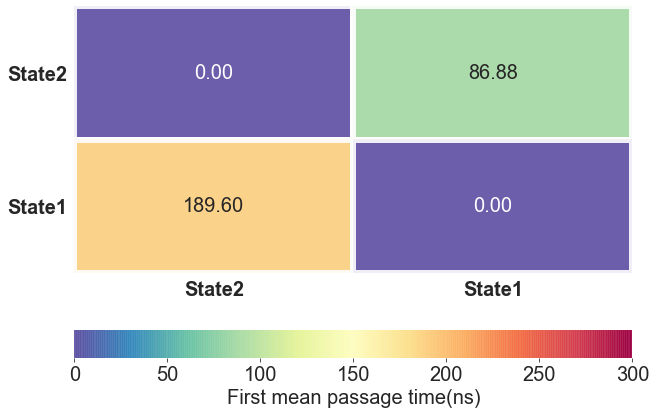

In [84]:
plt.figure(figsize=(10,7))

sns.heatmap(data=MPT,lw=5, annot=True,fmt="0.2f", cmap='Spectral_r',alpha=0.9, vmin=0, vmax=300, cbar_kws={'label':'First mean passage time(ns)','orientation':'horizontal'})
plt.xticks(np.arange(0.5,2.5),['State2','State1'], weight='bold')
plt.yticks(np.arange(0.5,2.5),['State2','State1'], rotation=0, weight='bold')

In [ ]:
pcca_samples = M.sample_by_distributions(M.metastable_distributions,100)

In [ ]:
outfiles = []
for k in range(0, 2):
    intstring = str(k+1)
    filename = 'samples_pcca_RMSD-2states'+ intstring + '.xtc'
    outfiles.append(filename)

pye.coordinates.save_trajs(reader, pcca_samples, outfiles = outfiles)